<a href="https://colab.research.google.com/github/IKE-Emma/AI-bootcamp-classification-competetion-Zindi_-/blob/main/content_base_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing The Required Dependencies

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ast
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns
from wordcloud import WordCloud

In [3]:
df1 = pd.read_csv('credits.csv')
df2 = pd.read_csv('titles.csv')

In [4]:
df1.head()

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


In [5]:
df2.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,48,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,"['crime', 'drama']",['US'],NaN,tt0075314,8.3,795222.0,27.612,8.2
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['comedy', 'fantasy']",['GB'],NaN,tt0071853,8.2,530877.0,18.216,7.8
3,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,['comedy'],['GB'],NaN,tt0079470,8.0,392419.0,17.505,7.8
4,tm190788,The Exorcist,MOVIE,12-year-old Regan MacNeil begins to adapt an e...,1973,R,133,['horror'],['US'],NaN,tt0070047,8.1,391942.0,95.337,7.7


### Data Exploration

As we'll explore in the next section, the genres alone can be used to provide a reasonably good content based recommendation. But before that, we need analyse some important aspects.

In [6]:
# plt.figure(figsize=(10,6))
# sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
# sns.countplot(df2['tmdb_popularity'].fillna(df2['tmdb_popularity'].median()))

In [7]:
df = df2.copy()

In [8]:
df.columns

Index(['id', 'title', 'type', 'description', 'release_year',
       'age_certification', 'runtime', 'genres', 'production_countries',
       'seasons', 'imdb_id', 'imdb_score', 'imdb_votes', 'tmdb_popularity',
       'tmdb_score'],
      dtype='object')

In [9]:
# Checking what the genres looks like
df['genres']

0                       ['documentation']
1                      ['crime', 'drama']
2                   ['comedy', 'fantasy']
3                              ['comedy']
4                              ['horror']
                      ...                
5801                 ['romance', 'drama']
5802           ['music', 'documentation']
5803                  ['family', 'drama']
5804               ['action', 'thriller']
5805    ['family', 'comedy', 'animation']
Name: genres, Length: 5806, dtype: object

In [10]:
# Checking what the production country looks like
df['production_countries']

0             ['US']
1             ['US']
2             ['GB']
3             ['GB']
4             ['US']
            ...     
5801          ['NG']
5802              []
5803    ['NG', 'CA']
5804              []
5805              []
Name: production_countries, Length: 5806, dtype: object

In [11]:
# Replacing false iteams in the production country with nan value

df['production_countries'].replace('False', np.nan, inplace=True)
df['production_countries'].fillna('[]', inplace=True)

In [12]:
# def format_column(row):
#     word = ''
#     lists = ast.literal_eval(row)
#     for i in lists:
#         word+=i['name']+" "
#     return (word.strip())

In [13]:
df['description']

0       This collection includes 12 World War II-era p...
1       A mentally unstable Vietnam War veteran works ...
2       King Arthur, accompanied by his squire, recrui...
3       Brian Cohen is an average young Jewish man, bu...
4       12-year-old Regan MacNeil begins to adapt an e...
                              ...                        
5801    A beautiful love story that can happen between...
5802    Rising star Edis's career journey with ups and...
5803    A man from Nigeria returns to his family in Ca...
5804    A family faces destruction in a long-running c...
5805    With winter behind them, Bheem and his townspe...
Name: description, Length: 5806, dtype: object

In [14]:
# setting parameters for the 
vectorizer = TfidfVectorizer(stop_words='english')

In [15]:
# Feature Engineering
df['features']=df['genres']+" "+df['production_countries']
df['features']

0                   ['documentation'] ['US']
1                  ['crime', 'drama'] ['US']
2               ['comedy', 'fantasy'] ['GB']
3                          ['comedy'] ['GB']
4                          ['horror'] ['US']
                        ...                 
5801             ['romance', 'drama'] ['NG']
5802           ['music', 'documentation'] []
5803        ['family', 'drama'] ['NG', 'CA']
5804               ['action', 'thriller'] []
5805    ['family', 'comedy', 'animation'] []
Name: features, Length: 5806, dtype: object

In [17]:
genre_popularity = (df.genres.str.split('|')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
genre_popularity.head(10)

['comedy']                     510
['drama']                      350
['documentation']              320
['comedy', 'drama']            141
['drama', 'comedy']            128
['reality']                    120
['drama', 'romance']           112
['comedy', 'documentation']     93
['animation']                   69
[]                              68
Name: genres, dtype: int64

(-0.5, 999.5, 399.5, -0.5)

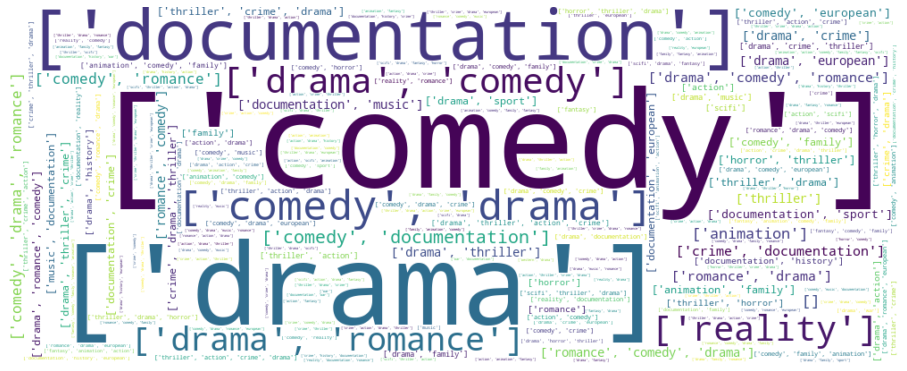

In [18]:
genre_wc = WordCloud(width=1000,height=400, background_color='white')
genre_wc.generate_from_frequencies(genre_popularity.to_dict())

plt.figure(figsize=(16, 8))
plt.imshow(genre_wc, interpolation="bilinear")
plt.axis('off')

### As we can see, the most frequent genres are Drama, reality Comedy and documentation, among others. We then have some other genres that are way less frequent such as Western, Fantasy or Sci-Fi.

As I previously pointed out, these are the genres that we want to give the most importance to when recommending. Why is that? As an example let's consider new user wants to find movies similar to Interstellar., which is a mixture of Sci-Fi, Drama, Mistery and Adventure. Say now that among the available movies to recommend we have a collection of Drama movies and some other Sci-Fi movies too. Which should we prioritise? In this case, it seems reasonable to assume that the less generic genre, Sci-Fi, will be the most relevant in terms of characterising the movie.

### Building a content based recommender
For the post, we will be building a fairly simple recommender, based on the movie genres. A fairly common approach is to use a tf-idf vectorizer.

While this approach is more commonly used on a text corpus, it possesses some interesting properties that will be useful in order to obtain a vector representation of the data. The expression is defined as follows:

netflix

Where we have the product of the term frequency, i.e. the amount of times a given term (genre) occurs in a document (genres of a movie), times the right side factor, which basically scales the term frequency depending on the amount of times a given term appears in all documents (movies).

The lesser the amount of movies that contain a given genre (df_i), the higher the resulting weight. The logarithm is basically to smoothen the result of the division, i.e. avoids huge differences as a result of the right hand term.

tf-idf
To obtain the tf-idf vectors I'll be using sklearn's TfidfVectorizer . However, we have to take into account some aspects particular to this problem. The usual setup when dealing with text data, is to set a word analyser and perhaps an ngram_range , which will also include the n-grams within the specified range. An example would be:


In [19]:
# Fitting the pre processed features created to a vectorizer
word_vectors = vectorizer.fit_transform(df['features'])

In [20]:
word_vectors.shape

(5806, 113)

In [21]:
# Getting the similarity scores of the vectorized words
similarity_scores = cosine_similarity(word_vectors)

In [22]:
similarity_scores.shape

(5806, 5806)

In [23]:
# Coverting indices to a pandas series
indices = pd.Series(df.index, index = df['title'])

In [24]:
# Checking the indices variable
indices

title
Five Came Back: The Reference Films       0
Taxi Driver                               1
Monty Python and the Holy Grail           2
Life of Brian                             3
The Exorcist                              4
                                       ... 
Fine Wine                              5801
Edis Starlight                         5802
Clash                                  5803
Shadow Parties                         5804
Mighty Little Bheem: Kite Festival     5805
Length: 5806, dtype: int64

In [25]:
indices = indices.groupby(indices.index).first()

In [26]:
# Defining a function that returns the first five recommeded movies based on the similarity score of the input movie
def recommend(n_title, similarity_scores, k=5):
    n_id = indices[n_title]
    similar_item_scores = list(enumerate(similarity_scores[n_id]))
    sorted_sim_score = sorted(similar_item_scores, key=lambda x:x[1], reverse=True)[1:k+1]
    m_index = [idx[0] for idx in sorted_sim_score]
    r_movies = df.iloc[m_index]['title']
    return r_movies

In [27]:
# Testing the algorithm to see it's performance
recommend('Taxi Driver', similarity_scores)

80        Adam: His Song Continues
83     In Defense of a Married Man
218                         Damini
279                           Blow
875               Shor in the City
Name: title, dtype: object

In [28]:
recommend('Monty Python and the Holy Grail', similarity_scores)

2070                         Mowgli: Legend of the Jungle
3                                           Life of Brian
78      Parrot Sketch Not Included: Twenty Years of Mo...
181                                Bill Hicks: Relentless
567                     Tim Minchin: So F**king Rock Live
Name: title, dtype: object

### Concluding
Overall, we've seen that quite a naive content based recommendation as the reviewed can provide fairly good recommendations.

A clear advantage of content based recommendations is that they don't suffer from the cold-start problem, since we only need basic information on a user (in this case a single movie) to provide similar recommendations based based on the items. Another interesting advantage is that we are able to recommend to users with unique tastes, as well as new an unpopular items.

An important drawback however is that it tends to recommend the same type of items to the user. In order to be able to recommend a different type of item, the user would have to have rated or show interest in the new type of item. This is a problem that Collaborative Filtering methods don't have, since the match here is done between neighbouring users with similar tastes, but different items rated.